In [11]:
import os
import sys
this = os.getcwd()
path = this[:this.rfind("/")]
if not path in sys.path: sys.path.append(path)

from datos import FEATURES_DISPONIBLES
from modelo import Modelo
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [5]:
import xgboost as xgb

In [17]:
class XGBoost(Modelo):
    """
    """
    
    def cargar_datos(self):
        """
        """
        excluir = {
            "tipodepropiedad", "ciudad", "provincia", "idzona", "fecha"
        }
        features = FEATURES_DISPONIBLES - excluir
        super().cargar_datos(features)
        self.train_data = self.train_data.drop(columns=["fecha"])
        self.test_data = self.test_data.drop(columns=["fecha"])
        self.submit_data = self.submit_data.drop(columns=["fecha"])
        
    def entrenar(self):
        """
        """
        pass
        

In [18]:
modelo = XGBoost()
modelo.cargar_datos()

instanciar demoro 0.0 segundos
cargar demoro 1.31 segundos


In [16]:
modelo.train_data.head()

,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio,ano,mes,dia,precio_metro_cubierto,precio_metro_total
id,,,,,,,,,,,,,,,,,,
86018,8.000,2.000,1.000,1.000,105.000,160.000,2012-03-01,False,False,False,True,False,565000.000,2012,3,1,5380.952,3531.250
273545,8.000,3.000,0.000,1.000,52.000,nan,2015-08-19,False,False,False,False,False,930000.000,2015,8,19,17884.615,nan
295862,0.000,2.000,2.000,2.000,60.000,66.000,2012-12-31,False,False,False,True,True,660000.000,2012,12,31,11000.000,10000.000
194850,10.000,3.000,nan,2.000,140.000,167.000,2015-12-23,False,False,False,False,False,1250000.000,2015,12,23,8928.571,7485.030
197782,20.000,4.000,3.000,3.000,420.000,420.000,2016-01-22,False,True,False,True,True,5500000.000,2016,1,22,13095.238,13095.238


In [27]:
label = 'gimnasio'
dtrain = xgb.DMatrix(modelo.train_data, label=modelo.train_data[label].values)
dtest = xgb.DMatrix(modelo.test_data, label=modelo.test_data[label].values)

In [28]:
params = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic', 'nthread': 4, 'eval_metric': 'auc'}
booster = xgb.train(params, dtrain)

In [46]:
modelo.test_data['pred'] = booster.predict(dtest)

In [47]:
pred = modelo.test_data[[label, 'pred']]

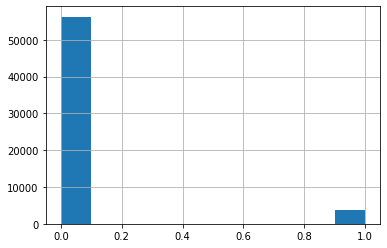

In [48]:
pred["pred"].hist()

In [49]:
pred["label"] = pred["pred"].map(lambda x: x > 0.5)

/home/mharfuch/.local/share/virtualenvs/7506-TP-cfKyodU4/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [57]:
pred["dif"] = ~(pred[label] == pred["label"])

/home/mharfuch/.local/share/virtualenvs/7506-TP-cfKyodU4/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [58]:
pred["dif"].value_counts()

False    60000
Name: dif, dtype: int64